In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from typing import Dict, Any
from collections import Counter

import numpy as np
import pandas as pd
import sklearn as sk
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, 
    average_precision_score, precision_recall_curve, plot_precision_recall_curve, make_scorer
)
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250
import dvu  # for visualization

import imodels

# change working directory to project root
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../..')

from experiments.config.config import EASY_DATASETS, HARD_DATASETS
from experiments.models.stablelinear import StableLinearClassifier
from experiments.models.stableskope import StableSkopeClassifier
from experiments.notebooks import viz
from experiments.util import get_comparison_result, get_clean_dataset, get_best_model_under_complexity, MODEL_COMPARISON_PATH

np.random.seed(0)

/accounts/projects/vision/chandan/imodels/experiments/notebooks


# dataset stats

In [ ]:
metadata = []
columns = ['name', 'samples', 'orig_features', 'features', 'class 0 ct', 'class 1 ct', 'majority class %']
orig_features = [9, 20, 3, 13, 10, 23, 91]
for i, (dataset_name, path) in enumerate(EASY_DATASETS + HARD_DATASETS):
    X, y, feature_names = get_clean_dataset(path=path)
    shape = X.shape
    class_counts = np.unique(y, return_counts=True)[1]
    metadata.append([dataset_name, shape[0], orig_features[i], shape[1], class_counts[0], class_counts[1], np.max(class_counts) / np.sum(class_counts)])
pd.DataFrame(metadata, columns=columns).set_index('name')

- Recreate original background gradient analysis from cache 

# complexity vs. test performance plots

In [30]:
baselines = [
    'random_forest', 
    'gradient_boosting', 
    'skope_rules', 
    'rulefit', 
    'fplasso', 
#     'fpskope',
    'brl',
    'brs']
metric = 'mean_PRAUC'

## hard datasets

In [4]:
ensembles = [
    'stbl_l2_mm0',
#     'stbl_l2_mm1',
    'stbl_l1_mm0',
#     'stbl_l1_mm1'
]
test_models = baselines + ensembles

In [5]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname, 
                          prefix='test') for mname in test_models
]

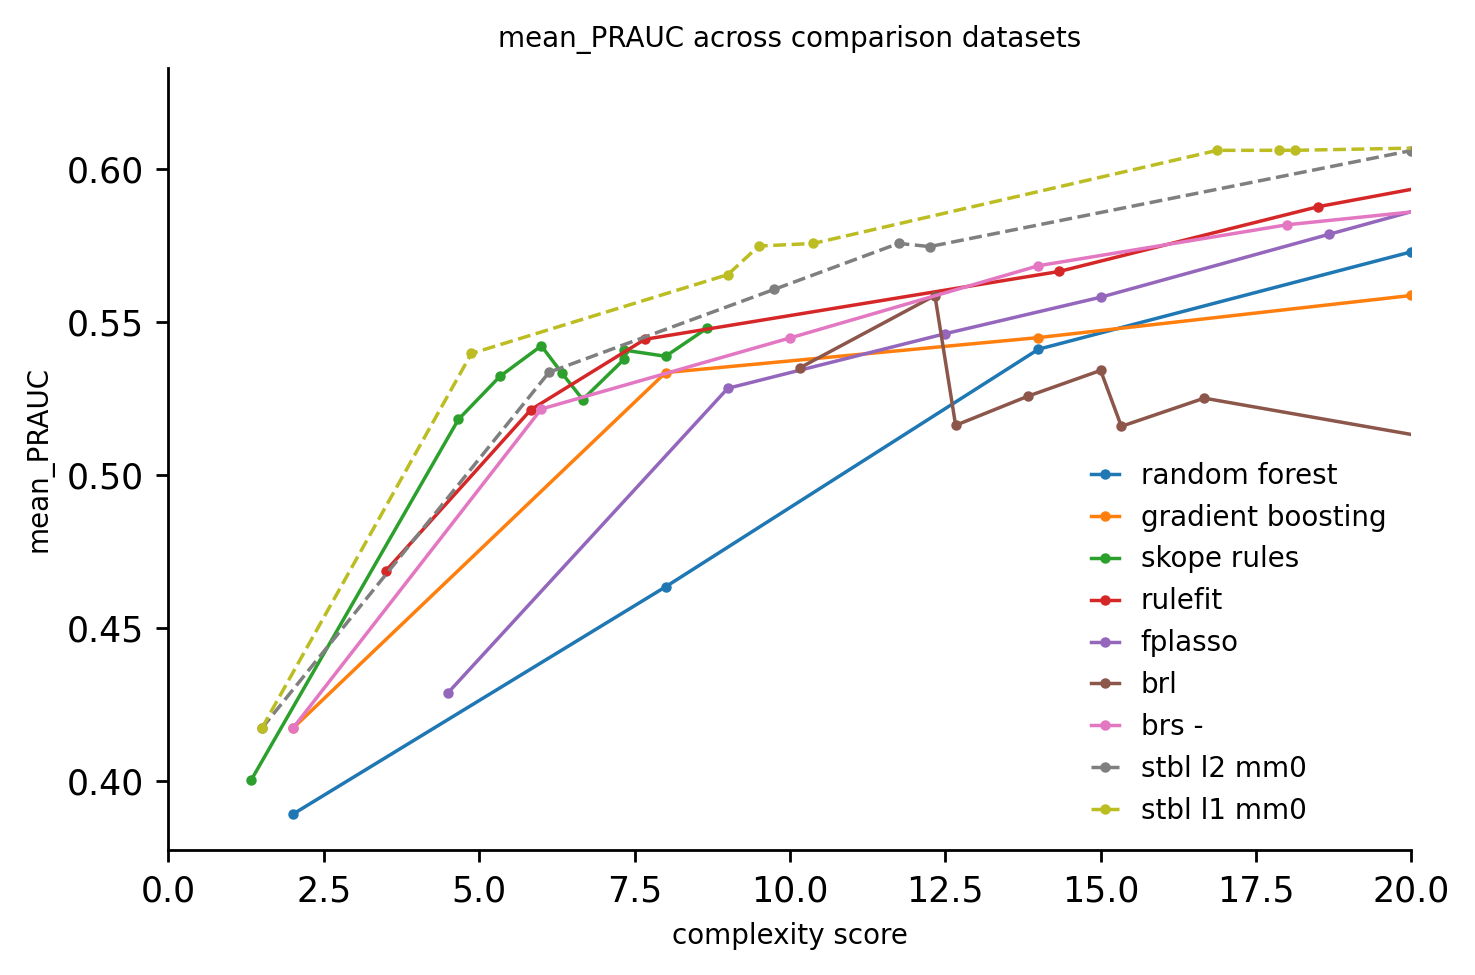

In [33]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 20))
viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

**check individual datasets**

In [ ]:
viz.viz_comparison_datasets(test_results, cols=1, figsize=(13, 23), test=True, line_legend=True, y_column='ROCAUC')
plt.show()

## easy datasets

In [15]:
ensembles = [
#     'stbl_l2_mm0',
#     'stbl_l2_mm1',
    'stbl_l1_mm0',
    'stbl_l1_mm1'
]
test_models = baselines + ensembles

In [16]:
test_results_easy = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname, 
                          prefix='test',
                          easy=True) for mname in test_models
]

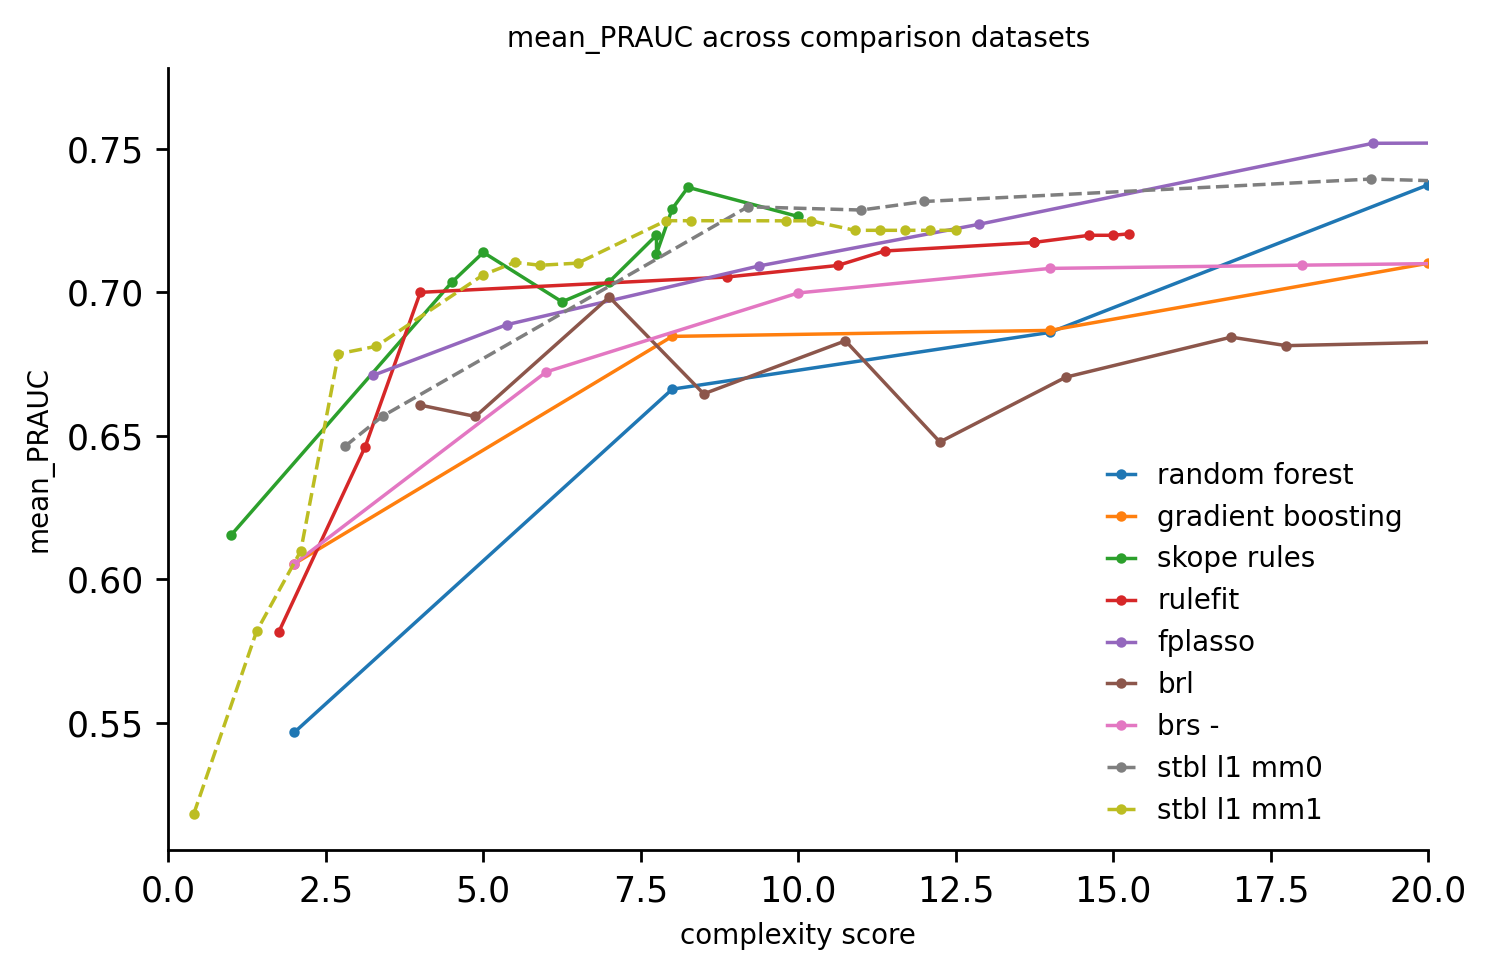

In [32]:
# mean_ROCAUC, mean_PRAUC, mean_accuracy, mean_complexity, mean_time
viz.viz_comparison_test_average(test_results_easy, metric=metric)
viz.savefig(f'test_easy_{metric}.pdf')
plt.xlim((0, 20))
plt.show()

**check individual datasets**

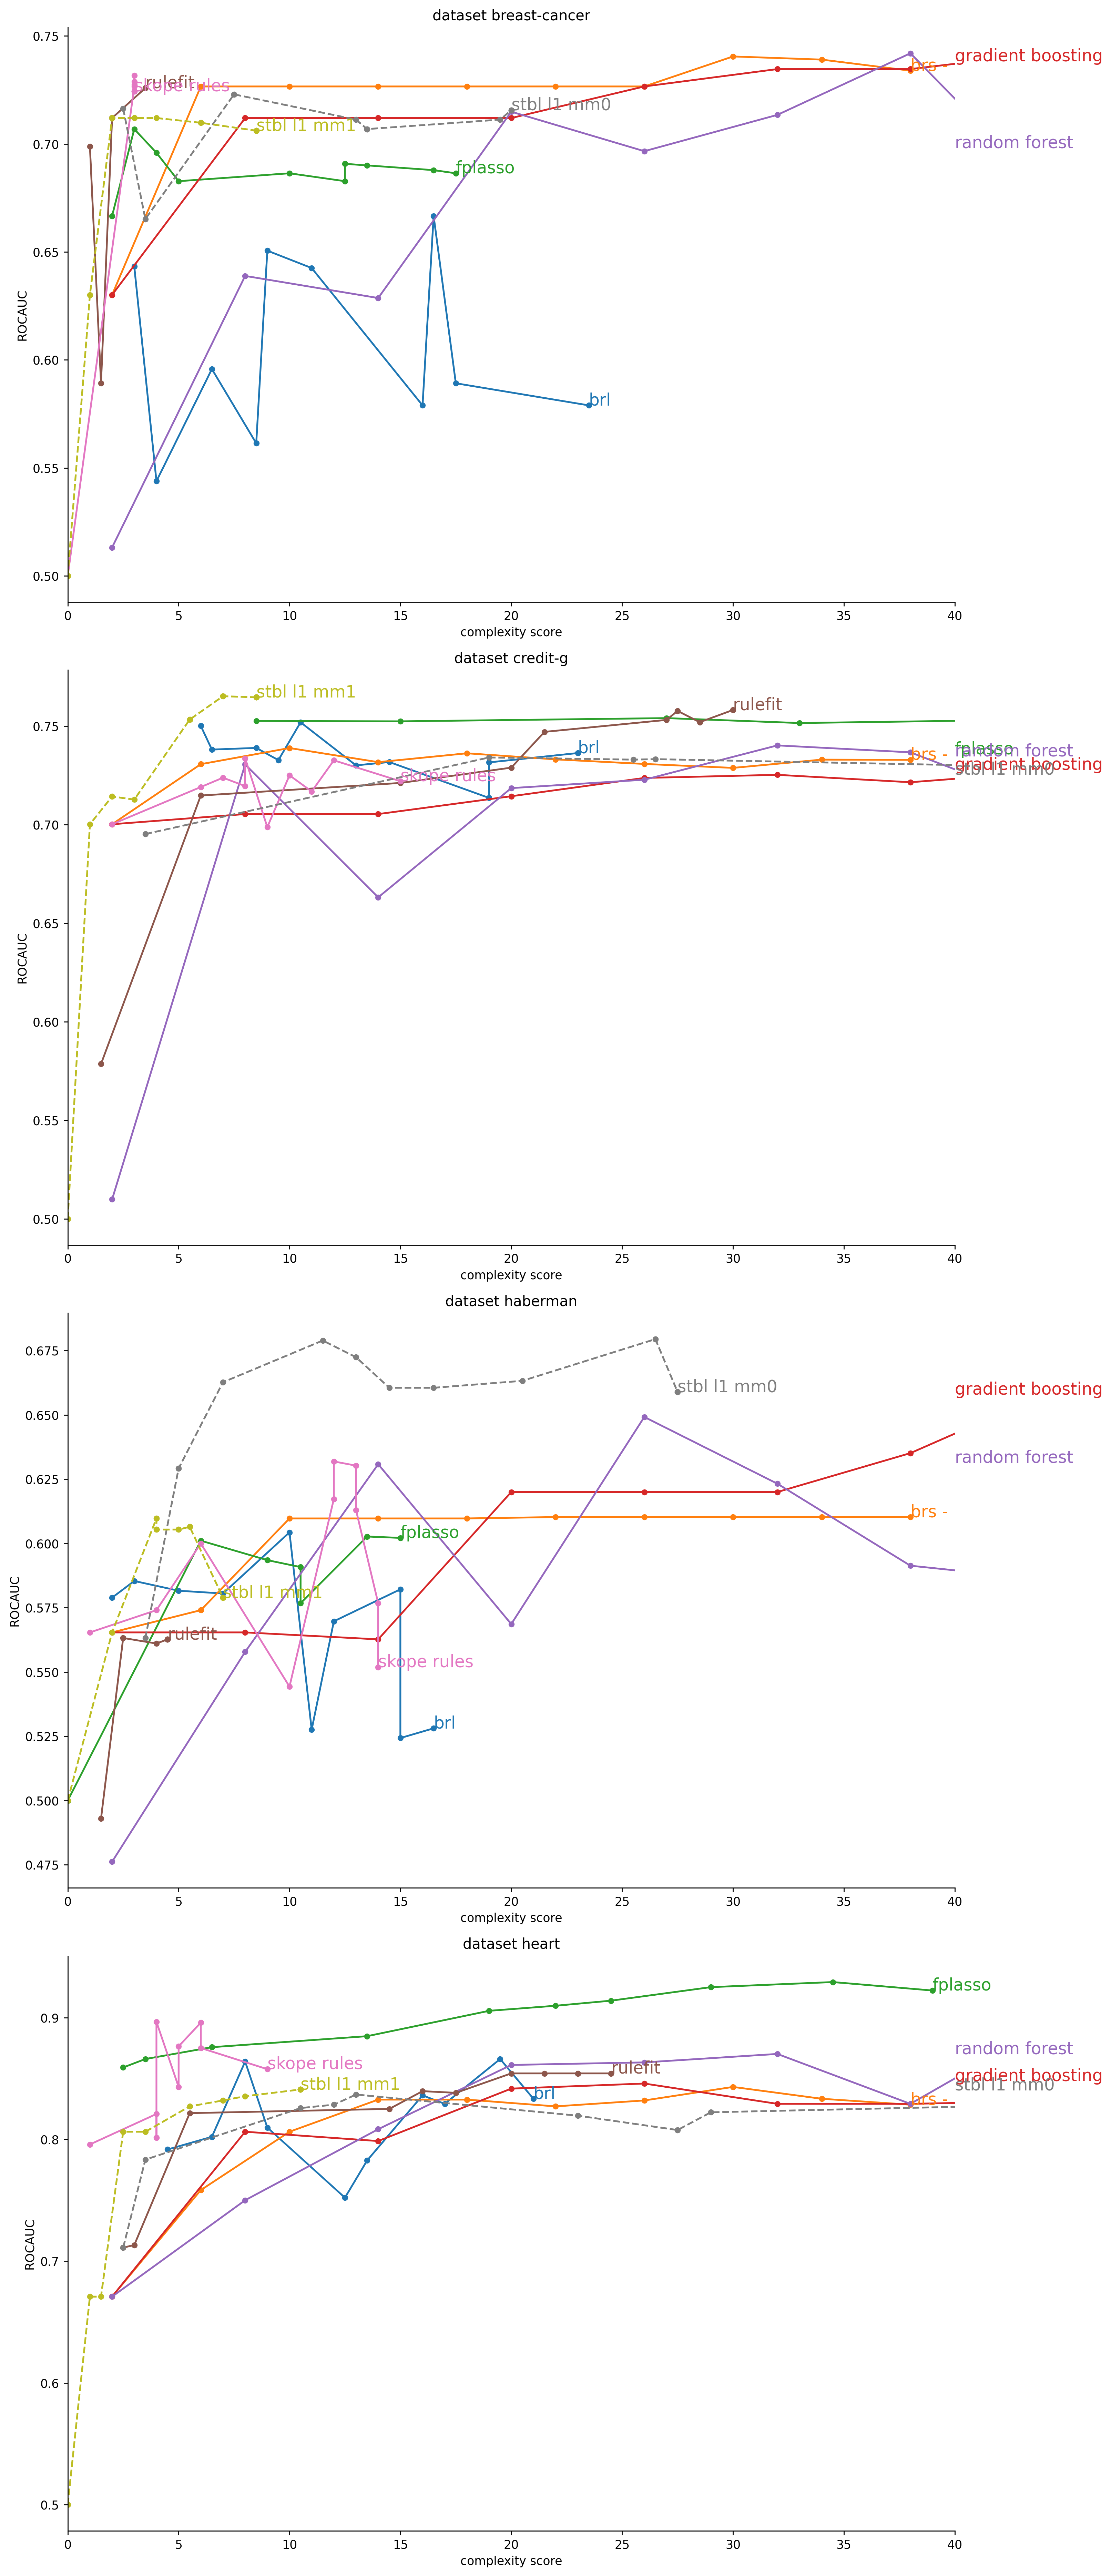

In [23]:
viz.viz_comparison_datasets(test_results_easy, cols=1, figsize=(13, 30), test=True, line_legend=True)
plt.show()

# complexity vs. test performance plots for all models - low data setting

## hard datasets

In [24]:
ensembles = [
    'stbl_l2_mm0',
#     'stbl_l2_mm1',
    'stbl_l1_mm0',
#     'stbl_l1_mm1'
]
test_models = baselines + ensembles

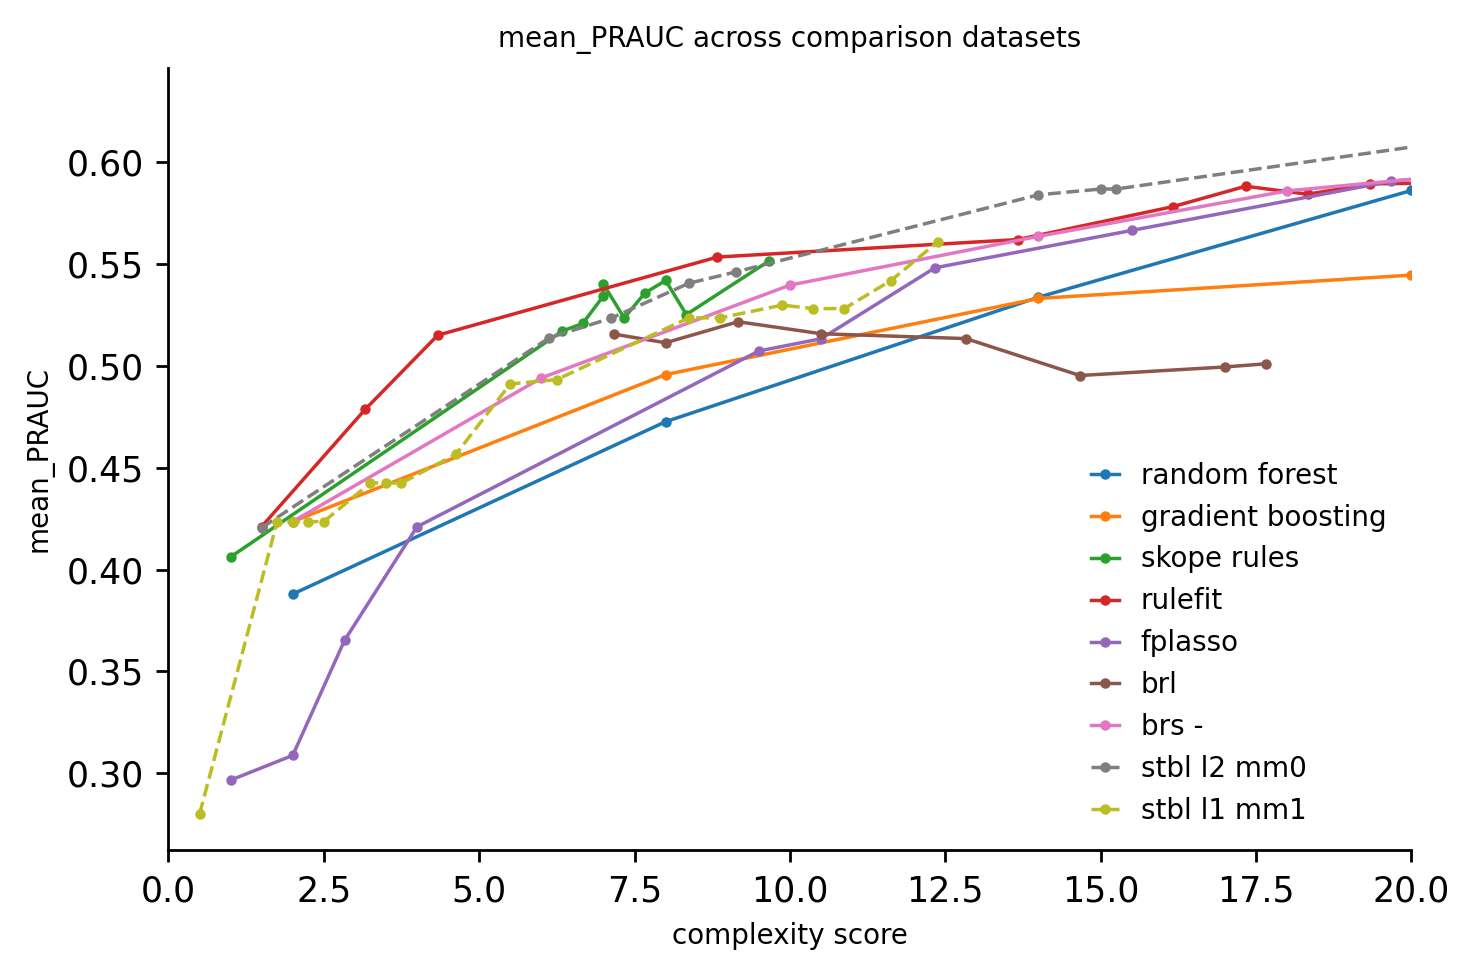

In [34]:
test_results_ld = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname, 
                          prefix='test',
                          low_data=True) for mname in test_models
]
viz.viz_comparison_test_average(test_results_ld, metric=metric)
plt.xlim((0, 20))
viz.savefig(f'test_hard_small_{metric}')
plt.show()

**check individual datasets**

In [ ]:
viz.viz_comparison_datasets(test_results_ld, cols=1, figsize=(13, 23), test=True, line_legend=True)
plt.show()

## easy datasets

In [35]:
ensembles = [
    'stbl_l2_mm0',
#     'stbl_l2_mm1',
#     'stbl_l1_mm0',
    'stbl_l1_mm1'
]
test_models = baselines + ensembles

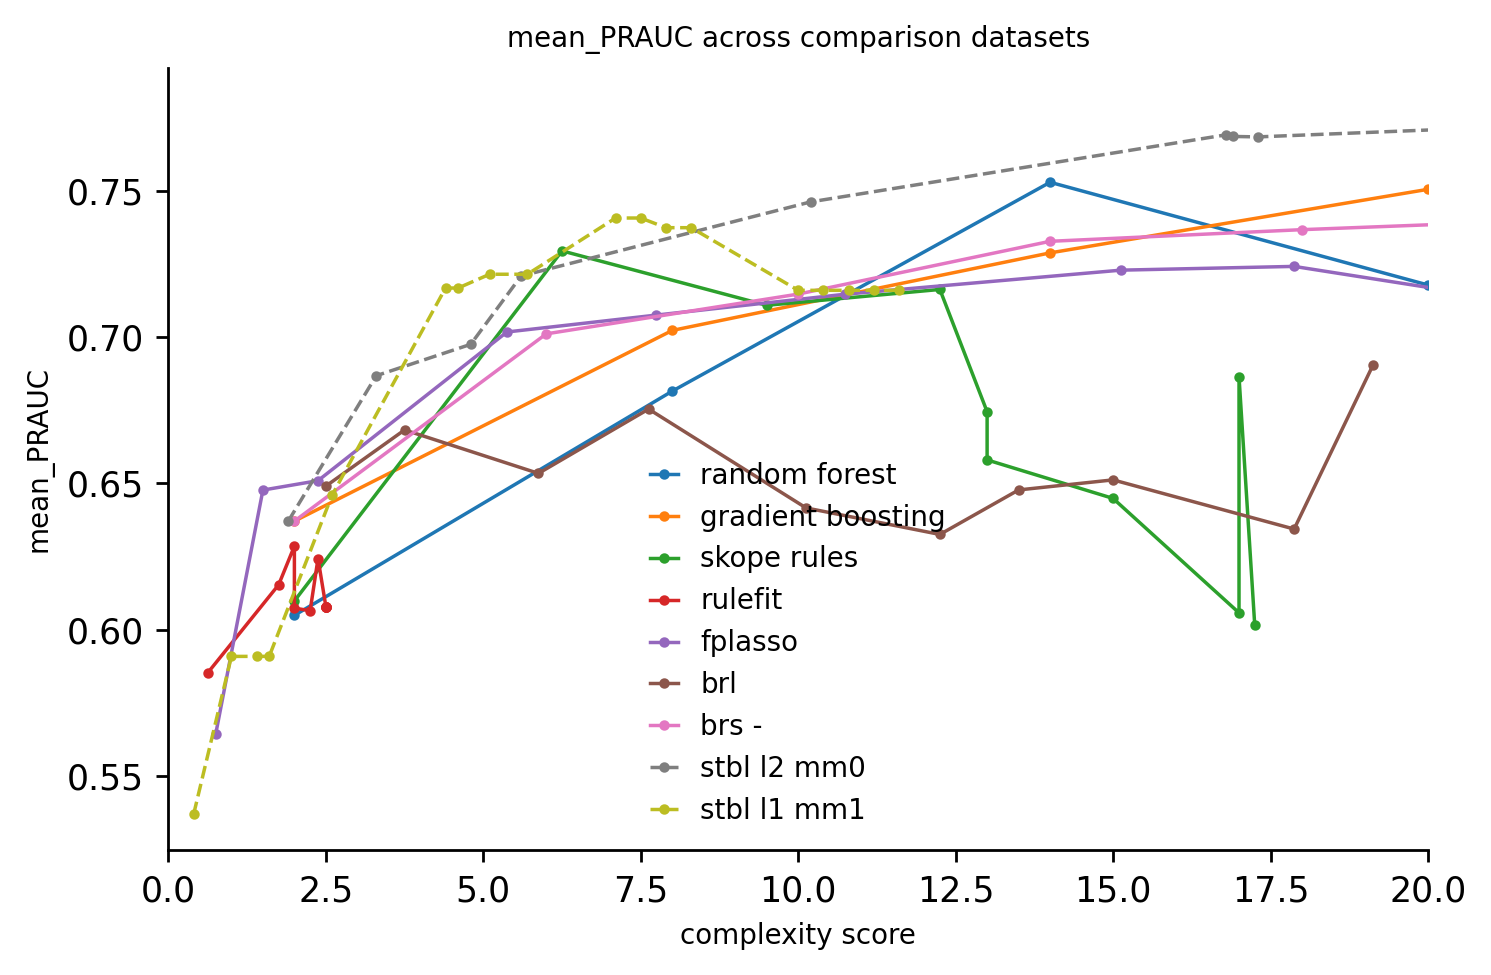

In [36]:
test_results_ld_easy = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname, 
                          prefix='test',
                          low_data=True,
                          easy=True) for mname in test_models
]
viz.viz_comparison_test_average(test_results_ld_easy, metric=metric)
viz.savefig(f'test_easy_small_{metric}')

plt.xlim((0, 20))
plt.show()

In [ ]:
viz.viz_comparison_datasets(test_results_ld_easy, cols=1, figsize=(13, 30), test=True, line_legend=True)
plt.show()

# recreate by loading from cache

In [18]:
# ds = [13, 15, 31, 43, 1574, 4, 56]
# rocauc_data = {d:[] for d in ds}
# avg_prec_data = {d:[] for d in ds}
# prec_data = {d:[] for d in ds}
# rec_data = {d:[] for d in ds}
# for d in ds:
#     all_rules = []
#     x, y = get_dataset(d)
#     xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=1)
#     weak_learners = [
#         ('skope_rules', imodels.SkopeRulesClassifier),
#         ('rulefit', imodels.RuleFitClassifier),
#         ('fplasso', imodels.FPLassoClassifier),
#         ('fpskope', imodels.FPSkopeClassifier),
#         ('brs', imodels.BoostedRulesClassifier)
#     ]
#     weak_learner_inst = get_best_models_under_complexity(5, weak_learners)
#     for m in weak_learner_inst:
#         m.fit(xtrain, ytrain)
#         rocauc_data[d].append(roc_auc_score(ytest, m.predict_proba(xtest)[:, 1]))
#         avg_prec_data[d].append(average_precision_score(ytest, m.predict_proba(xtest)[:, 1]))
#     ensemble_kwargs = {'weak_learners': weak_learner_inst, 'max_complexity': 5}
#     ensembles = (
#         [StableLinearClassifier(**ensemble_kwargs, min_mult=m) for m in [0, 1, 2]]
#         + [StableLinearClassifier(**ensemble_kwargs, penalty='l2', min_mult=m) for m in [0, 1, 2]]
#         + [StableSkopeClassifier(**ensemble_kwargs, min_mult=m) for m in [0, 1, 2]]
#     )
#     for m in ensembles:
#         m.fit(xtrain, ytrain)
#         rocauc_data[d].append(roc_auc_score(ytest, m.predict_proba(xtest)[:, 1]))
#         avg_prec_data[d].append(average_precision_score(ytest, m.predict_proba(xtest)[:, 1]))
    
# ind = ['skp', 'rf', 'fpl', 'fps', 'brs', 
#        'ensemble-lasso-md0', 'ensemble-lasso-md1', 'ensemble-lasso-md2',
#        'ensemble-ridge-md0', 'ensemble-ridge-md1', 'ensemble-ridge-md2', 
#        'ensemble-skope-md0', 'ensemble-skope-md1', 'ensemble-skope-md2']
# res_rocauc = pd.DataFrame(rocauc_data, index=ind)
# res_avg_prec = pd.DataFrame(avg_prec_data, index=ind)
# res_rocauc['mean'] = res_rocauc.mean(axis=1)
# res_avg_prec['mean'] = res_avg_prec.mean(axis=1)

# res_rocauc.style.background_gradient()
# res_avg_prec.style.background_gradient()


# np.random.seed(0)
# x, y = get_dataset(1574)
# xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(x, y, random_state=0)
# m = imodels.BayesianRuleListClassifier()
# m.fit(xtrain, ytrain)
# print(roc_auc_score(ytest, m.predict_proba(xtest)[:, 1]))
# # print(m.rules_)

In [19]:
# from sklearn.neural_network import MLPClassifier

In [20]:
# x, y, feat_names = get_clean_dataset('experiments/data/ICPSR_03986/DS0001/data_clean.csv')
# xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(x, y, test_size=0.2, random_state=0)

# mlp_accs = []
# mlp_rocaucs = []
# for hidden_layer_sizes in [(200,), (200,200), (500,500)]:
#     m = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=500)
#     m.fit(xtrain, ytrain)
#     mlp_accs.append(roc_auc_score(ytest, m.predict_proba(xtest)[:, 1]))
#     mlp_rocaucs.append(accuracy_score(ytest, m.predict(xtest)))

In [21]:
# mlp_rocaucs